In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


import itertools as it

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import time as time

In [2]:
data = pd.read_csv('movies_classification_updated.csv')
data.drop(['Unnamed: 0' , 'title'], axis=1, inplace=True)
data.head()

,belongs_to_collection,budget,revenue,runtime,Animation,Comedy,Family,Adventure,Fantasy,Romance,...,Mystery,War,Foreign,Music,Documentary,Western,TV Movie,english,release_year,release_month
0,1,30000000,1.0,81.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,1995,10.0
1,0,65000000,1.0,104.0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,1995,12.0
2,1,0,0.0,101.0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,1995,12.0
3,0,16000000,1.0,127.0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,1995,12.0
4,1,0,1.0,106.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1995,2.0


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

X = data.drop('revenue', axis=1)
y = data.revenue

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an instance of the SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

In [14]:
start_time = time.time()

params = {'n_estimators': [2000],
          'max_features': [1],
          'max_depth': [10, 20],
          'min_samples_split': [2, 10],
          'max_leaf_nodes': [20, 40]
         }

param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
oob_recall = [0]*len(param_list)

i=0
for pr in param_list:
    model = RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                  max_features=pr[1], n_jobs=-1).fit(X_train_imputed,y_train)
    
    oob_pred = (model.oob_decision_function_[:,1]>=0.5).astype(int)     
    oob_recall[i] = precision_score(y_train, oob_pred)
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("max precision = ", np.max(oob_recall))
print("params= ", param_list[np.argmax(oob_recall)])

time taken =  9.348600443204244  minutes
max precision =  0.7792553191489362
params=  (2000, 1, 10, 2, 20)


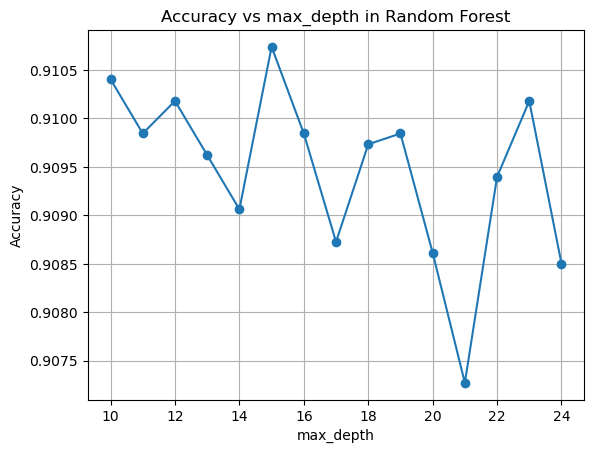

In [19]:
# Define the values of max_depth to explore
max_depth_values = range(10, 25)

# Train random forest models with different max_depth values
accuracies = []
for max_depth in max_depth_values:
    rf = RandomForestClassifier(random_state=1, max_depth=max_depth)
    rf.fit(X_train_imputed, y_train)
    accuracy = rf.score(X_test_imputed, y_test)
    accuracies.append(accuracy)

# Plot the max_depth values vs accuracies
plt.plot(max_depth_values, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_depth in Random Forest')
plt.grid(True)
plt.show()

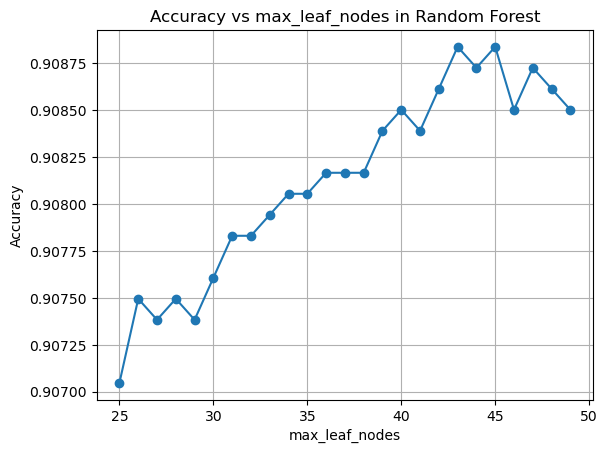

In [20]:
# Define the values of max_leaf_nodes to explore
max_leaf_nodes_values = range(25, 50)  

# Train random forest models with different max_leaf_nodes values
accuracies = []
for max_leaf_nodes in max_leaf_nodes_values:
    rf = RandomForestClassifier(random_state=1, max_leaf_nodes=max_leaf_nodes)
    rf.fit(X_train_imputed, y_train)
    accuracy = rf.score(X_test_imputed, y_test)
    accuracies.append(accuracy)

# Plot the max_leaf_nodes values vs accuracies
plt.plot(max_leaf_nodes_values, accuracies, marker='o')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_leaf_nodes in Random Forest')
plt.grid(True)
plt.show()

In [22]:
model = RandomForestClassifier(random_state=1, max_features=1, n_estimators = 2000, 
                               oob_score=True, max_depth = 15, max_leaf_nodes = 45, min_samples_split=2).fit(X_train_imputed, y_train)

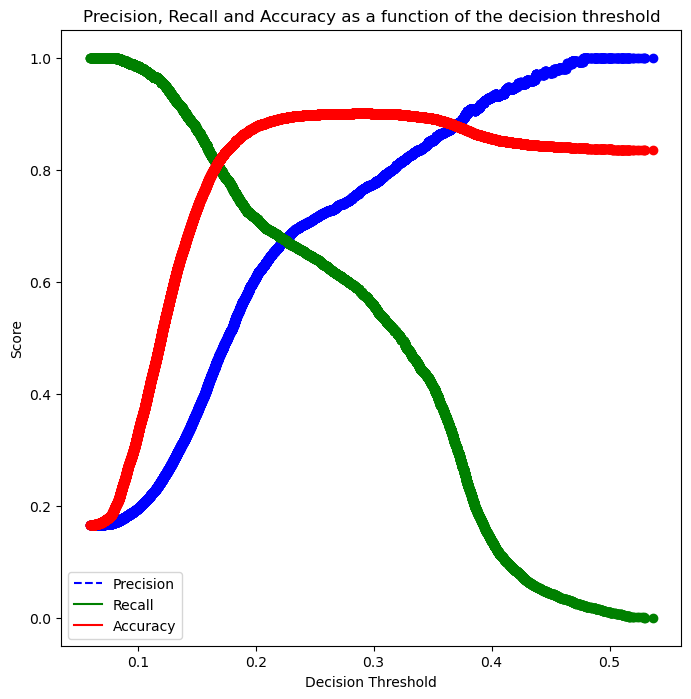

In [23]:
y_pred_prob = model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_pred_prob)
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = y_pred_prob > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision, Recall and Accuracy as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  86.08501118568232
ROC-AUC:  0.89271320918774
Precision:  0.9154929577464789
Recall:  0.17567567567567569


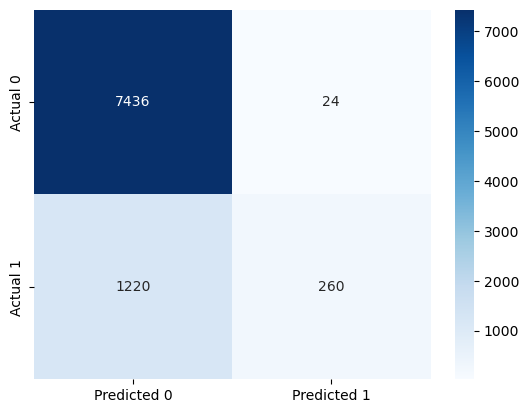

In [25]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.39

y_pred_prob = model.predict_proba(X_test_imputed)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  89.8993288590604
ROC-AUC:  0.8976284327222666
Precision:  0.7041755130927105
Recall:  0.6722972972972973


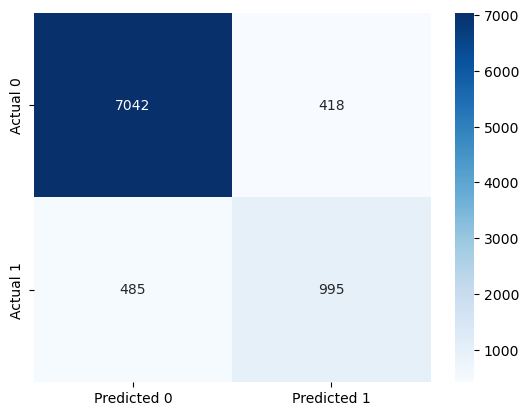

In [30]:
model = RandomForestClassifier(random_state=40).fit(X_train_imputed, y_train)

# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.38

y_pred_prob = model.predict_proba(X_test_imputed)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');